In [1]:
import os
import re
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import umap
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

# Clustering GitHub Pull Requests and Error Logs

This notebook explores how we can cluster GitHub pull request messages, commit data, and related stack traces to better understand recurring issues and patterns in codebases.  

The idea is that by embedding text (PR titles, commit messages, error logs) into vectors and running clustering algorithms, we can highlight groups of similar problems which could help with debugging, triaging, or even identifying duplicated work.

In [2]:
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

sns.set(style='whitegrid', context='notebook', rc={'figure.figsize': (12, 8)})

def clean_text(text: str) -> str:
    """Lightweight text cleaner for PR and commit messages."""
    text = str(text).lower()
    text = re.sub(r'http\S+|www\.\S+', ' ', text)  # Remove URLs
    text = re.sub(r'```.*?```', ' ', text, flags=re.DOTALL)  # Remove code blocks
    text = re.sub(r'`[^`]*`', ' ', text)  # Remove inline code
    text = re.sub(r'[^\w\s]', ' ', text)  # Remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()  # Normalize whitespace
    return text

print("Setup Complete.")

Setup Complete.


## 1. Load and Inspect Data

We’ll start by loading the dataset of pull request metadata and stack traces.  
I’m assuming a CSV file (`ghprdata.csv`) is available locally, but you can replace this path with your own dataset if needed.


In [3]:
try:
    # Load CSV file into a DataFrame
    df = pd.read_csv('ghprdata.csv', header=None, low_memory=False)
    column_names = [
        'project_name', 'project_owner', 'project_description', 'tags', 'language',
        'commit_sha_before', 'commit_sha_after', 'diff', 'commit_message', 'date',
        'code_before', 'code_after', 'path_before', 'path_after', 'pr_title', 'pr_body'
    ]
    df.columns = column_names
    print(f"Successfully loaded 'ghprdata.csv' and assigned new column names. Shape: {df.shape}")

except FileNotFoundError:
    raise FileNotFoundError("Error: 'ghprdata.csv' not found. Please ensure the dataset is in the same directory.")
except Exception as e:
    print(f"An error occurred: {e}")
    print("Ensure your CSV has exactly 16 columns if you are using the predefined column names.")

# Quick check: dataset shape and preview
display(df.head(3))
df.info()

Successfully loaded 'ghprdata.csv' and assigned new column names. Shape: (3026, 16)


,project_name,project_owner,project_description,tags,language,commit_sha_before,commit_sha_after,diff,commit_message,date,code_before,code_after,path_before,path_after,pr_title,pr_body
0,Gadgetbridge,Freeyourgadget,Github mirror of Gadgetbridge - A free and clo...,"activity post processing,activity/health,andro...",Java,000f1ab4780fc9460975791c52597f7c04e15be7,ece0f094eb56219ae5188dcd37b90590a9f4029d,diff --git a/app/src/main/java/nodomain/freeyo...,Fix duplicated DeviceType key introduced by th...,20180902,"/* Copyright (C) 2015-2018 Andreas Shimokawa,...","/* Copyright (C) 2015-2018 Andreas Shimokawa,...",app/src/main/java/nodomain/freeyourgadget/gadg...,app/src/main/java/nodomain/freeyourgadget/gadg...,Roidmi: fix duplicated DeviceType key,Fix duplicated DeviceType key introduced by th...
1,MaterialDateTimePicker,wdullaer,Pick a date or time on Android in style,"bug,duplicate,enhancement,help wanted,invalid,...",Java,0024dbdd6ba3cc7797cc0b1ae537dcdc488c4c27,288f0a9c4b01ffcedf9fec41dd7c0373ee55f277,diff --git a/library/src/main/java/com/wdullae...,No repro steps known but observed in crash rep...,20190209,/*\n * Copyright (C) 2013 The Android Open Sou...,/*\n * Copyright (C) 2013 The Android Open Sou...,library/src/main/java/com/wdullaer/materialdat...,library/src/main/java/com/wdullaer/materialdat...,NPE fix: DayPickerView accessibilityAnnouncePa...,No repro steps known but observed in crash rep...
2,processing,processing,Source code for the Processing Core and Develo...,"android,arm,arm64,book,cantfix,core,critical,d...",Java,005681edd7b222a51d6bdf64cdcba489cd617d1d,1ebf79592c9bedfca838a6e58463470dc1445b84,diff --git a/core/src/processing/core/PApplet....,A couple of Tools in the Base menu are not ren...,20140403,/* -*- mode: java; c-basic-offset: 2; indent-t...,/* -*- mode: java; c-basic-offset: 2; indent-t...,core/src/processing/core/PApplet.java,core/src/processing/core/PApplet.java,"Fix NPE in PDE, affecting color picker and oth...",A couple of Tools in the Base menu are not ren...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3026 entries, 0 to 3025
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   project_name         3026 non-null   object
 1   project_owner        3026 non-null   object
 2   project_description  2947 non-null   object
 3   tags                 2969 non-null   object
 4   language             3026 non-null   object
 5   commit_sha_before    3026 non-null   object
 6   commit_sha_after     3026 non-null   object
 7   diff                 3026 non-null   object
 8   commit_message       2298 non-null   object
 9   date                 3026 non-null   int64 
 10  code_before          3026 non-null   object
 11  code_after           3026 non-null   object
 12  path_before          3026 non-null   object
 13  path_after           3026 non-null   object
 14  pr_title             3022 non-null   object
 15  pr_body              2298 non-null   object
dtypes: int

## 2. Generate Sentence Embeddings

To capture meaning in commit messages and error logs, we’ll use a transformer-based model (`all-MiniLM-L6-v2`).  
This turns each message into a dense vector representation.


In [4]:
TEXT_CANDIDATES = ['pr_title', 'pr_body', 'commit_message', 'project_description']
METADATA_CANDIDATES = {
    'numeric': ['comments_count', 'lines_changed', 'files_changed', 'commits_count'],
    'categorical': ['language', 'project_name'] 
}

text_cols = [col for col in TEXT_CANDIDATES if col in df.columns and df[col].notna().sum() > 0]
numeric_cols = []
for col in METADATA_CANDIDATES['numeric']:
    if col in df.columns:
        numeric_series = pd.to_numeric(df[col], errors='coerce')
        if numeric_series.notna().sum() > 0 and numeric_series.nunique() > 1:
            numeric_cols.append(col)

categorical_cols = [col for col in METADATA_CANDIDATES['categorical'] if col in df.columns and df[col].notna().sum() > 0]

if text_cols:
    HAS_TEXT = True
    print(f"Strategy: Text-based pipeline using columns: {text_cols}")
elif numeric_cols or categorical_cols:
    HAS_TEXT = False
    print("Strategy: Metadata-only pipeline.")
    print(f"Using numeric columns: {numeric_cols}")
    print(f"Using categorical columns: {categorical_cols}")
else:
    raise ValueError("No suitable text or metadata columns found for clustering.")

Strategy: Text-based pipeline using columns: ['pr_title', 'pr_body', 'commit_message', 'project_description']


In [5]:
if HAS_TEXT:
    df['combined_text'] = df[text_cols].astype(str).agg(' '.join, axis=1)
    df['cleaned_text'] = df['combined_text'].apply(clean_text)
    try:
        from sentence_transformers import SentenceTransformer
        print("Generating Sentence-BERT embeddings (this may take a moment)...")
        # Load pre-trained embedding model
        model = SentenceTransformer('all-MiniLM-L6-v2')
        # Encode commit messages into vectors
        features = model.encode(df['cleaned_text'].tolist(), show_progress_bar=True)
        print(f"Feature matrix shape: {features.shape}")
    except ImportError:
        raise ImportError("Please install sentence-transformers: `pip install sentence-transformers`")
else:
    print("Preprocessing metadata features...")
    df_meta = df.copy()
    for col in numeric_cols:
        df_meta[col] = pd.to_numeric(df_meta[col], errors='coerce').fillna(0)
    for col in categorical_cols:
        df_meta[col] = df_meta[col].fillna('Unknown').astype(str)
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_cols),
            ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
        ],
        remainder='drop'
    )
    features = preprocessor.fit_transform(df_meta)
    print(f"Feature matrix shape: {features.shape}")

Generating Sentence-BERT embeddings (this may take a moment)...


Batches:   0%|          | 0/95 [00:00<?, ?it/s]

Feature matrix shape: (3026, 384)


## 3. Reduce Dimensions for Visualization

Embeddings are high-dimensional (384D).  
We’ll use UMAP to project them down to 2D so we can later visualize clusters.


In [6]:
print("Computing UMAP embedding for visualization...")
# Apply UMAP for 2D projection
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=RANDOM_STATE)
embedding = reducer.fit_transform(features)

Computing UMAP embedding for visualization...


## 4. Cluster the Data

Now we’ll apply KMeans clustering to group together semantically similar commit messages and logs.  
The number of clusters can be adjusted (we’ll start with 10).


In [7]:
K_CLUSTERS = 5
print(f"Running KMeans clustering with k={K_CLUSTERS}...")
# Cluster embeddings with KMeans
kmeans = KMeans(n_clusters=K_CLUSTERS, random_state=RANDOM_STATE, n_init=10)
cluster_labels = kmeans.fit_predict(features)

# Store results back in DataFrame
df['cluster_label'] = cluster_labels
silhouette = silhouette_score(features, cluster_labels)
davies_bouldin = davies_bouldin_score(features, cluster_labels)

print("\n--- Clustering Evaluation ---")
print(f"Silhouette Score: {silhouette:.3f} (higher is better, range -1 to 1)")
print(f"Davies-Bouldin Index: {davies_bouldin:.3f} (lower is better, >0)")

Running KMeans clustering with k=5...

--- Clustering Evaluation ---
Silhouette Score: 0.042 (higher is better, range -1 to 1)
Davies-Bouldin Index: 4.503 (lower is better, >0)


## 5. Visualize the Clusters

Let’s plot the UMAP projection and color each point by its assigned cluster.  
This gives us an intuitive picture of how the model grouped our data.


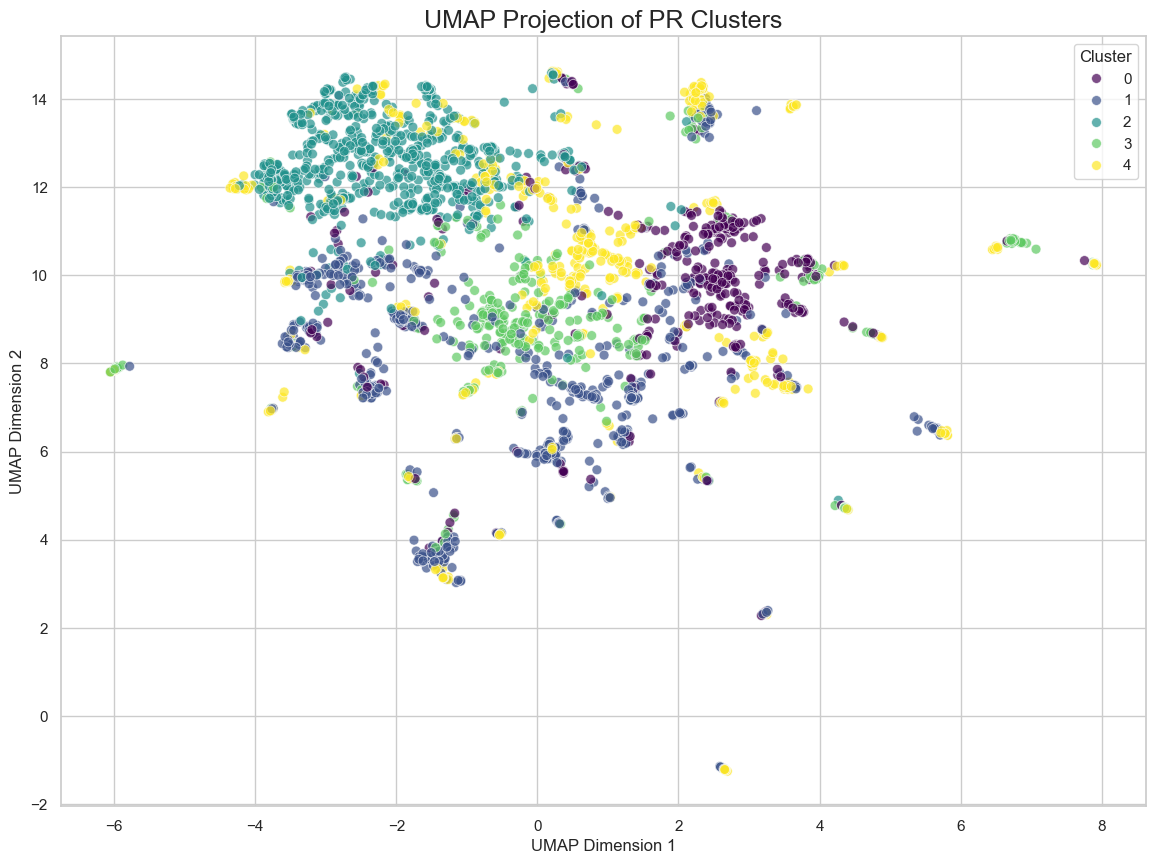

In [8]:
plt.figure(figsize=(14, 10))
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=df['cluster_label'], palette='viridis', s=50, alpha=0.7)
plt.title('UMAP Projection of PR Clusters', fontsize=18)
plt.xlabel('UMAP Dimension 1', fontsize=12)
plt.ylabel('UMAP Dimension 2', fontsize=12)
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

## 6. Inspect Cluster Examples

To verify that clustering makes sense, we’ll print a few commit messages from each cluster.


In [9]:
print("\n--- Cluster Samples ---")
# Print sample commit messages from each cluster
for i in range(K_CLUSTERS):
    print(f"\n--- Cluster {i} (Size: {df[df['cluster_label'] == i].shape[0]}) ---")
    sample_df = df[df['cluster_label'] == i].head(3)
    if HAS_TEXT:
        for _, row in sample_df.iterrows():
            print(f"  - {row['cleaned_text'][:150]}...")
    else:
        for _, row in sample_df.iterrows():
            print(f"  - {row[numeric_cols + categorical_cols].to_dict()}")

output_filename = 'ghpr_clusters_output.csv'
df.to_csv(output_filename, index=False)
print(f"\nResults saved to '{output_filename}'")


--- Cluster Samples ---

--- Cluster 0 (Size: 426) ---
  - fix potential wakelock the endlessjabber wakeful service can in some cases hold a wakelock i don t have enough insight into this project to say if whe...
  - fix intermittent scans using the prior scan end time to calculate when we can stop the current scan cycle causes an immediate scan stop under two cond...
  - fixed the scope caching error this is a slightly fix to fix the scope caching this is a slightly fix to fix the scope caching a fast lightweight and m...

--- Cluster 1 (Size: 780) ---
  - fix npe in pde affecting color picker and other tools a couple of tools in the base menu are not rendering due to nullpointerexceptions early in the p...
  - backlog 16118 fixed issue with field lengths in text input master pr 7 1 0 0 pr jira case master pr 7 1 0 0 pr jira case pentaho data integration etl ...
  - fix 670 use files move instead of file rename to move files because file rename does not support overwriting existing f